In [1]:
import pandas as pd
from gemelli.rpca import feature_correlation_table
from biom import load_table
import numpy as np
import glob
import json
from skbio import OrdinationResults
from biom import load_table

import matplotlib.patches as mpatches
from matplotlib.pyplot import cm
from matplotlib.colors import to_hex
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Import data

In [2]:
ord_joint = OrdinationResults.read('../results/joint-rpca/Original/ord.txt')
ord_joint_feats = ord_joint.features.copy()
axis_use = 1 # use PC2
# import tables data 
metadata_subset = pd.read_csv('../data/split-matched-data/metadata.tsv', sep='\t', index_col=0)
tables = {}
for table_ in glob.glob('../data/split-matched-data/*.biom'):
    if '16S' in table_:
        continue
    if 'gene.biom' in table_:
        continue
    bt_tmp = load_table(table_)
    bt_tmp_df = pd.DataFrame(bt_tmp.matrix_data.toarray(), bt_tmp.ids('observation'), bt_tmp.ids())
    bt_tmp_df = bt_tmp_df[metadata_subset.index]
    id_set = set(ord_joint_feats.index) & set(bt_tmp.ids('observation'))
    ord_joint_feats_tmp = ord_joint_feats.loc[list(id_set), :]
    ord_joint_feats_tmp = ord_joint_feats_tmp.sort_values(by=axis_use, ascending=False)
    tables[table_.split('/')[-1].split('.')[0]] = [bt_tmp, bt_tmp_df, ord_joint_feats_tmp]
tables.keys()

dict_keys(['metabolite', 'mag', '18S', 'gene_module', 'metabolomics'])

In [3]:
metab_ids = pd.read_excel('../data/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

bt_tmp, df_tmp, ord_tmp = tables['metabolite']
keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
df_tmp = df_tmp.loc[list(keep_metab), :]
ord_tmp = ord_tmp.loc[list(keep_metab), :].sort_values(by=axis_use, ascending=False)
tables['metabolite'] = [bt_tmp, df_tmp, ord_tmp]

## Build network

In [4]:
# annots for tables
taxonomy_18s = pd.read_csv('../data/annotations/18S_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_18s = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_18s.index, taxonomy_18s.Taxon.values)}
taxonomy_18s = pd.DataFrame(taxonomy_18s).T
taxonomy_18s_nosp = taxonomy_18s.drop([' s'], axis=1)

taxonomy_mag = pd.read_csv('../data/annotations/MAG_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_mag = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_mag.index, taxonomy_mag.Taxon.values)}
taxonomy_mag = pd.DataFrame(taxonomy_mag).T
taxonomy_mag[taxonomy_mag == ''] = np.nan

In [5]:
#load top and bottom features
with open("../results/joint-rpca/network/joint_decomposer_feats.json") as json_file:
    features_used_all = json.load(json_file)

with open("../results/joint-rpca/network/rpca_decomposer_feats.json") as json_file:
    features_used_rpca = json.load(json_file)

In [6]:
# make sure no overlap
print({k_:set(v1) & set(v2) for k_, (v1, v2) in features_used_all.items()})
print({k_:set(v1) & set(v2) for k_, (v1, v2) in features_used_rpca.items()})

{'metabolite': set(), 'mag': set(), '18S': set(), 'gene_module': set(), 'metabolomics': set()}
{'metabolite': set(), 'mag': set(), '18S': set(), 'gene_module': set(), 'metabolomics': set()}


In [7]:
feature_feature_correlation = feature_correlation_table(ord_joint)
feature_feature_correlation.head(5)

featureid,metab_1,metab_2,metab_3,metab_4,metab_5,metab_6,metab_9,metab_10,metab_11,metab_12,...,sp|Q4Z9G3|PORTL_BPTWO_Probable_portal_protein;_XpXrXs,sp|Q52118|YMO3_PANSE_Uncharacterized_protein_in_mobD_3'region;_Xh,sp|Q5PLI4|DGCQ_SALPA_Probable_diguanylate_cyclase_DgcQ;_Xh,sp|Q5UQ90|YL532_MIMIV_Cytochrome_P450-like_protein_L532;_XhXs,sp|Q5UQG2|YL498_MIMIV_Probable_zinc-type_alcohol_dehydrogenase-like_protein_L498;_XhXs,sp|Q5UQI9|YR836_MIMIV_Uncharacterized_protein_R836;_Xu,sp|Q7VIN2|NPD_HELHP_NAD-dependent_protein_deacylase;_Xh,sp|Q8ZNY9|PRP1_SALTY_Serine/threonine-protein_phosphatase_1;_Xh,sp|Q93J06|LIP2_STRCO_Lipase_2;_Xh,sp|Q9USU3|FBH1_SCHPO_F-box_DNA_helicase_protein_1;_Xh
featureid,,,,,,,,,,,,,,,,,,,,,
metab_1,1.000000,0.950286,0.101352,0.984747,0.420760,0.122384,0.918941,-0.269318,-0.473904,-0.334884,...,-0.980094,0.140919,0.463914,-0.012220,0.311884,-0.108284,0.623929,0.321508,0.581883,-0.732900
metab_2,0.950286,1.000000,-0.175955,0.889841,0.122672,0.355225,0.842529,0.009973,-0.203890,-0.361493,...,-0.940898,-0.058314,0.216892,-0.278941,0.070982,0.066470,0.400511,0.419711,0.432676,-0.794607
metab_3,0.101352,-0.175955,1.000000,0.196816,0.742522,-0.956283,0.347035,-0.946683,-0.891130,0.518662,...,-0.064148,0.188248,0.714083,0.576518,0.384673,-0.241049,0.631158,0.113007,0.070661,0.458150
metab_4,0.984747,0.889841,0.196816,1.000000,0.560452,0.052777,0.904753,-0.350563,-0.575702,-0.383619,...,-0.949564,0.277633,0.589625,0.161888,0.464779,-0.262737,0.731480,0.191729,0.688941,-0.695063
metab_5,0.420760,0.122672,0.742522,0.560452,1.000000,-0.524905,0.424393,-0.798595,-0.863812,-0.179348,...,-0.376901,0.732394,0.851382,0.839965,0.883150,-0.652607,0.830096,-0.343410,0.713743,-0.102104


In [8]:
features_to_use = features_used_all.copy() #options: features_used_all, features_used_rpca
all_features = set([v_ for k_, (v1, v2) in features_to_use.items() ##v1 is the numerator, v2 is the denominator
                    for v_ in list(v2)]) & set(feature_feature_correlation.index)
feature_feature_correlation_subset = feature_feature_correlation.loc[list(all_features), list(all_features)]
feature_feature_correlation_subset.shape####eemsamdklandn

(89, 89)

In [9]:
new_index = []
index_dict = {'metabolite': [], 'mag': [], '18S': [], 
              'gene_module': [], 'metabolomics': []}
modality_map = {}
association_map = {}

nums_all = [v_ for k, v in features_to_use.items() for v_ in v[0]]
dens_all = [v_ for k, v in features_to_use.items() for v_ in v[1]]

for ind_ in feature_feature_correlation_subset.index:
    if ind_ in taxonomy_18s_nosp.index:
        label_ = taxonomy_18s_nosp.loc[ind_, :].dropna()
        label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
        new_index.append(label_)
        index_dict['18S'].append(label_)
        modality_map[label_] = 'Eukaryotes (18S)'
        if ind_ in nums_all:
            association_map[label_] = 'day zero'
        else:
            association_map[label_] = 'advanced'
    elif ind_ in taxonomy_mag.index:
        label_ = taxonomy_mag.loc[ind_, :].dropna()
        label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
        new_index.append(label_)
        index_dict['mag'].append(label_)
        modality_map[label_] = 'Bacterial Genomes (MetaG)'
        if ind_ in nums_all:
            association_map[label_] = 'day zero'
        else:
            association_map[label_] = 'advanced'
    elif ind_ in metab_ids.index:
        label_ = metab_ids.loc[ind_, 'most specific class']
        new_index.append(label_)
        index_dict['metabolite'].append(label_)
        modality_map[label_] = 'Metabolites'
        if ind_ in nums_all:
            association_map[label_] = 'day zero'
        else:
            association_map[label_] = 'advanced'
    else:
        new_index.append(ind_)
        if ind_ in nums_all:
            association_map[ind_] = 'day zero'
        else:
            association_map[ind_] = 'advanced'
        if ind_ in tables['mag'][1].index:
            index_dict['mag'].append(ind_)
            modality_map[ind_] = 'Bacterial Genomes (MetaG)'
        elif ind_ in tables['18S'][1].index:
            index_dict['18S'].append(ind_)
            modality_map[ind_] = 'Eukaryotes (18S)'
        elif ind_ in tables['gene_module'][1].index:
            index_dict['gene_module'].append(ind_)
            modality_map[ind_] = 'Functions (MetaG)'
        #elif ind_ in tables['gene'][1].index:
        #    modality_map[ind_] = 'Metagenomics (genes)'
        elif ind_ in tables['metabolomics'][1].index:
            index_dict['metabolomics'].append(ind_)
            modality_map[ind_] = 'Metabolites'
              
        
# clean up
new_index = ['drop' if len(str(i_)) == 0 else i_ for i_ in new_index]
new_index = ['drop' if str(i_) == 'nan' else i_ for i_ in new_index]
new_index = ['drop' if 'metab' in str(i_) else i_ for i_ in new_index]
new_index = [i_.replace('_',' ') for i_ in new_index]

# group
feature_feature_correlation_subset_relabel = feature_feature_correlation_subset.copy()
feature_feature_correlation_subset_relabel['new_label'] = new_index
old_to_new_index2 = dict(zip(feature_feature_correlation_subset_relabel.new_label, 
                             feature_feature_correlation_subset_relabel.index))
feature_feature_correlation_subset_relabel = feature_feature_correlation_subset_relabel.groupby('new_label').mean().T
feature_feature_correlation_subset_relabel['new_label'] = new_index
feature_feature_correlation_subset_relabel = feature_feature_correlation_subset_relabel.groupby('new_label').mean().T
feature_feature_correlation_subset_relabel.index.name = 'axis1'
feature_feature_correlation_subset_relabel.columns.name = 'axis2'
if 'drop' in feature_feature_correlation_subset_relabel.index: 
    feature_feature_correlation_subset_relabel = feature_feature_correlation_subset_relabel.drop(['drop'], axis=1).drop(['drop'], axis=0)
feature_feature_correlation_subset_relabel.head(5)


axis2,0DH:ubiquinone oxidoreductase mitochondria,Acinetobacter baumannii B (s),Acinetobacter rudis (s),Adhesin protein transport system,Animalia ( k),Apiotrichum ( g),Arginine/lysine/histidine/glutamine transport system,Arginine/ornithine transport system,Bacteroides E (g),Benzene and substituted derivatives,...,Tissierellales (o),Trehalose transport system,Trichosporonaceae ( fs),Type I signiture cas proteins,Tyrosine biosynthesis prephanate to pretyrosine to tyrosine,Universal Cas proteins,Vagococcus A lutrae (s),Wohlfahrtiimonadaceae (f),Wohlfahrtiimonas chitiniclastica (s),Yarrowia ( g)
axis1,,,,,,,,,,,,,,,,,,,,,
0DH:ubiquinone oxidoreductase mitochondria,1.000000,0.590542,0.779711,0.898789,0.696879,0.665600,0.829612,0.824419,0.546224,0.097297,...,0.415900,0.364552,0.560137,0.772521,0.862609,0.676430,0.608047,0.192291,0.691970,0.352590
Acinetobacter baumannii B (s),0.590542,1.000000,0.557950,0.641732,0.323941,0.007919,0.656965,0.195981,-0.187394,-0.710815,...,-0.360659,-0.187306,-0.266666,0.197918,0.415213,-0.077874,-0.005876,-0.591647,0.173133,-0.185799
Acinetobacter rudis (s),0.779711,0.557950,1.000000,0.972325,0.670988,0.362171,0.722850,0.843522,0.671667,-0.126610,...,0.548297,0.167471,0.467111,0.875800,0.959598,0.697066,0.818830,0.310460,0.904884,0.552532
Adhesin protein transport system,0.898789,0.641732,0.972325,1.000000,0.688929,0.447952,0.791462,0.850382,0.622539,-0.110949,...,0.482704,0.194851,0.472010,0.854231,0.964132,0.682922,0.755934,0.228768,0.855837,0.466544
Animalia ( k),0.696879,0.323941,0.670988,0.688929,0.826383,0.757685,0.843833,0.799299,0.554512,0.271508,...,0.494994,0.697731,0.681765,0.798094,0.702151,0.728762,0.591898,0.385219,0.608512,0.590568


In [10]:
#clean lists in index_dict
for modality, feature in index_dict.items():
    clean_lst = ['drop' if len(str(i_)) == 0 else i_ for i_ in feature]
    clean_lst = ['drop' if str(i_) == 'nan' else i_ for i_ in clean_lst]
    clean_lst = [i_.replace('_',' ') for i_ in clean_lst]
    #drop features
    index_dict[modality] = [i_ for i_ in clean_lst if i_ != 'drop']

In [11]:
mags_of_interest = ['Oblitimonas alkaliphila (s)', 'Ignatzschineria (g)', 'Acinetobacter rudis (s)',
                    'Morganella morganii (s)',  'Bacteroides E (g)', 'Ignatzschineria cameli (s)', 
                    'Savagea sp009740415 (s)']

#subset for the mags of interest
feature_feature_correlation_subset_relabel.loc[mags_of_interest, mags_of_interest]

axis2,Oblitimonas alkaliphila (s),Ignatzschineria (g),Acinetobacter rudis (s),Morganella morganii (s),Bacteroides E (g),Ignatzschineria cameli (s),Savagea sp009740415 (s)
axis1,,,,,,,
Oblitimonas alkaliphila (s),1.000000,0.985755,0.740049,0.721973,0.950500,0.960144,0.985062
Ignatzschineria (g),0.985755,1.000000,0.753235,0.724319,0.949478,0.973186,0.980379
Acinetobacter rudis (s),0.740049,0.753235,1.000000,0.997192,0.671667,0.792737,0.714856
Morganella morganii (s),0.721973,0.724319,0.997192,1.000000,0.646470,0.766646,0.691617
Bacteroides E (g),0.950500,0.949478,0.671667,0.646470,0.973365,0.970451,0.981668
Ignatzschineria cameli (s),0.960144,0.973186,0.792737,0.766646,0.970451,1.000000,0.985229
Savagea sp009740415 (s),0.985062,0.980379,0.714856,0.691617,0.981668,0.985229,0.999906


In [19]:
feature_feature_correlation_subset_relabel.to_csv('../results/joint-rpca/network/advanced-associated-network.csv')

In [13]:
# Transform it in a links data frame (3 columns only):
links = feature_feature_correlation_subset_relabel.stack().reset_index()
links.columns = ['var1', 'var2', 'value']

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[(links.value.abs() > links.value.abs().quantile([0.8]).values[0]) \
                         & (links['var1'] != links['var2']) ]

# Keep self loops
#links_filtered= pd.concat([links.loc[(links.value.abs() > links.value.abs().quantile([0.9]).values[0])], 
#                          links.loc[ (links['var1'] == links['var2'])]], axis=0)
links_filtered.shape

(596, 3)

In [14]:
unique_feats_to_keep = links_filtered.var1.unique()
#transform to original labels with old_to_new_index
unique_feats_original = [old_to_new_index2[x] for x in links_filtered.var1.unique()]

#save decomposer network features
#pd.DataFrame(unique_feats_original).to_csv('../results/joint-rpca/Original/decomposer_network_features_advanced-associated.csv')

In [15]:
#sanity check
#make pandas dataframe
sanity_df = pd.DataFrame(zip(unique_feats_original, unique_feats_to_keep), 
                         columns=["Original label", "Adjusted label"])
sanity_df.head(10)

,Original label,Adjusted label
0,0DH:ubiquinone_oxidoreductase_mitochondria,0DH:ubiquinone oxidoreductase mitochondria
1,UTK.bins.107,Acinetobacter rudis (s)
2,Adhesin_protein_transport_system,Adhesin protein transport system
3,fed846c55d7d619c6d5ef6b499bb5c69,Animalia ( k)
4,1fccaf33a96b52f2af8f5bf91acc8a1f,Apiotrichum ( g)
5,Arginine/lysine/histidine/glutamine_transport_...,Arginine/lysine/histidine/glutamine transport ...
6,Arginine/ornithine_transport_system,Arginine/ornithine transport system
7,SHSU_active.final.81,Bacteroides E (g)
8,metab_2325,Benzene and substituted derivatives
9,1bf1f0a861f411b0851c7cfefff7d931,Candida ( g)


In [16]:
color_map_list = set(modality_map.values())
colors = [to_hex(c) for c in cm.Set1_r(np.linspace(0, 1, len(color_map_list)))]
color_map = {k:v for k, v in zip(color_map_list, colors)}
modality_map_label = {str(k).replace('_',' '):v for k, v in modality_map.items()}
color_map['Functions (MetaG)'] = '#50C878' # green
color_map['Metabolites'] = '#CF9FFF' # purple
color_map['Bacterial Genomes (MetaG)'] = '#FF7518' # orange 
color_map['Eukaryotes (18S)'] = '#FF0000' # red 
map_shape = {'advanced':400, 'day zero':100}
assoc_map_label = {str(k).replace('_',' '):map_shape[v] for k, v in association_map.items()}

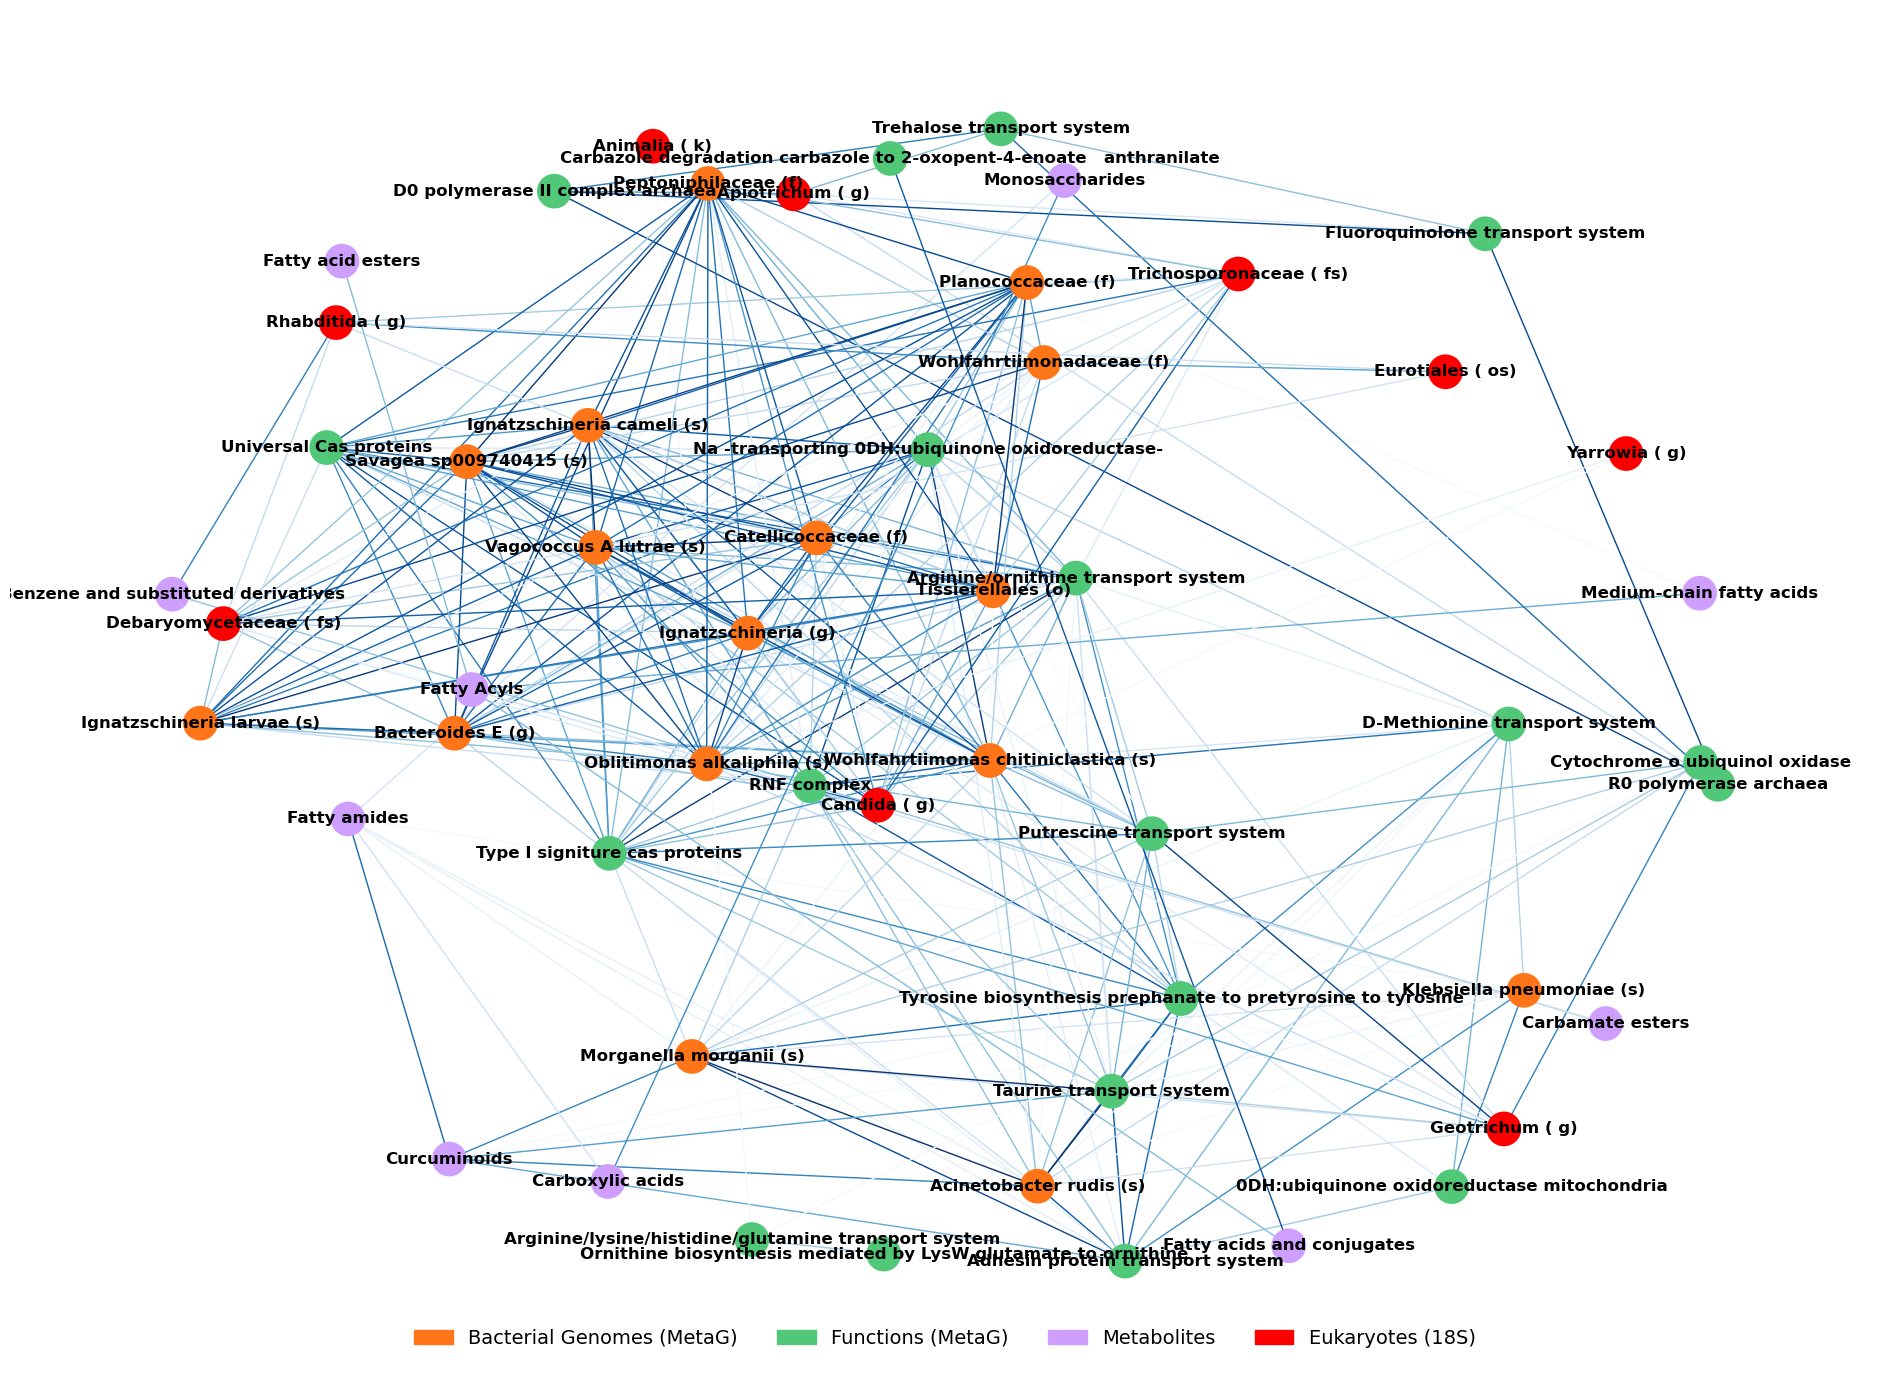

In [17]:
num_iterations = 20

for iteration in range(num_iterations):

    # Build your graph
    G = nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
    # Plot the network:
    values = range(links_filtered.shape[0])

    #pos = nx.kamada_kawai_layout(G)
    pos = nx.spring_layout(G, k=1.8)

    fig, ax = plt.subplots(1, 1, figsize=(19, 14)) 

    y_off = 3

    nx.draw(G, with_labels=True,
            pos = {k:([v[0], v[1]+y_off]) for k,v in pos.items()},
            node_color=[color_map[modality_map_label[node[0]]]
                        for node in G.nodes(data=True)], 
            #node_size=[assoc_map_label[node[0]]*4
            #            for node in G.nodes(data=True)], 
            node_size=400,
            edge_color=[abs(feature_feature_correlation_subset_relabel.loc[u, v])
                        for u, v in G.edges],
            edge_cmap= plt.cm.Blues,
            linewidths=5,
            width=1,
            font_size=12, font_weight='bold', ax=ax)


    handles_ = [mpatches.Patch(color=c_, label=modality_) for modality_, c_ in color_map.items()]
    legend = ax.legend(handles=handles_, loc='upper center', bbox_to_anchor=(0.5, 0.05),
               prop={'size':14},
               title="",
               fancybox=True,
               framealpha=.0,
               ncol=4, markerscale=1.5)
    legend.get_title().set_fontsize('16')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)

    plt.tight_layout()

    #plt.savefig(f'../results/figures/advanced-network-{iteration}.png',
    #            dpi=600, 
    #            bbox_inches='tight',
    #            edgecolor='none')
    
    #plt.show()
    if iteration == 0:
        plt.show()
    else:
        plt.close()